In [1]:
import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.regular as regular
import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.averager as averager
import mlgrad.weights as weights

from mlgrad import fg, erm_fg, irgd, erm_irgd, averager_fg

# import sklearn.linear_model as linear_model
# import sklearn.datasets as datasets
# import sklearn.metrics as metrics
# import sklearn.decomposition as decomposition

#import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper', 'seaborn-white'])
plt.matplotlib.rcParams["figure.dpi"] = 120
plt.matplotlib.rcParams['savefig.dpi'] = 120

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## US Judge Ratings

In [2]:
df = pd.read_csv('data/USJudgeRatings.csv', sep='\t')
#df

In [3]:
#pd.scatter_matrix(df, figsize=(15,10))
#plt.show()

In [4]:
X = DILG = df['DILG'].values
Y = PHYS = df['PHYS'].values

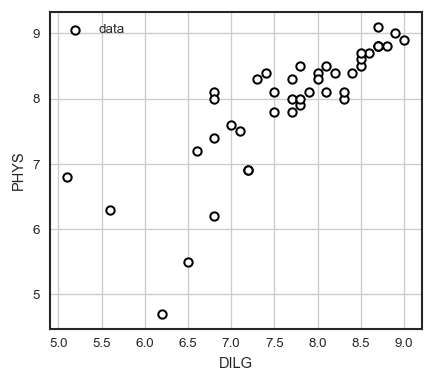

In [5]:
plt.figure(figsize=(4, 3.5))
plt.scatter(X, Y, s=25, marker='o', c='w', edgecolors='k', linewidths=1.2, label='data')
plt.grid(1)
plt.minorticks_on()
plt.legend(loc='upper left')
plt.xlabel('DILG')
plt.ylabel('PHYS')
plt.show()

In [6]:
param_init_q = np.random.random((2,))
lm_line_q = model.LinearModel(param_init_q)
loss_func_q = loss.ErrorLoss(func.Comp(func.Quantile(0.4), func.Square()))
alg_gd_q = erm_fg(X.reshape(-1,1), Y, lm_line_q, loss_func_q)

102 [ 1.05359026  0.89416552]


In [7]:
param_init_e = np.random.random((2,))
lm_line_e = model.LinearModel(param_init_e)
loss_func_e = loss.ErrorLoss(func.Comp(func.Expectile(0.6), func.Square()))
alg_gd_q = erm_fg(X.reshape(-1,1), Y, lm_line_e, loss_func_e)

95 [ 0.93755164  0.88752968]


In [8]:
#param_init = np.random.random((2,))
param_init = np.array([0.,-1.])
lm_line = model.LinearModel(param_init)
#loss_func = loss.ErrorLoss(func.Square())
loss_func = loss.ErrorLoss(func.Absolute())
#loss_func = loss.ErrorLoss(func.Sqrt(2.0))
penalty_func = func.Quantile_AlphaLog(0.01, 0.5)
#penalty_func = func.Sqrt(0.1)

d = {"u":[],"param":[], "K":[], "Ka":[], 'lval':[]}
def callback(alg):
    d["u"].append(alg.weights.average.u)
    d["lval"].append(alg.gd.lval_min)
    d["param"].append(alg.gd.model.lm_line.param.base.copy())
    d["K"].append(alg.gd.K)
    d["Ka"].append(alg.weights.average.K)

#avrfunc = avragg.Average_Iterative(penalty_func, tol=1.0e-6)
avrfunc = averager_fg(penalty_func)
alg_gd = fg(lm_line, loss_func)
alg_weights = weights.MWeights(avrfunc, alg_gd)
alg_pbfg = erm_irgd(X.reshape(-1,1), Y, alg_gd, alg_weights, callback=callback)

TypeError: __init__() got an unexpected keyword argument 'param_averager'

In [ ]:
xrange = np.linspace(X.min()*0.9, X.max()*1.1, 40)

plt.figure(figsize=(4, 3.5))
plt.scatter(X, Y, s=25, marker='o', c='w', edgecolors='k', linewidths=1.2, label='data')
#plt.plot(xrange, rlm_results.predict(xrange), marker='o', label='huber', color='k', markersize=4)
plt.plot(xrange, lm_line_q.evaluate_all(xrange.reshape(-1,1)), marker='v', label='quantile', color='k', markersize=5)
plt.plot(xrange, lm_line_e.evaluate_all(xrange.reshape(-1,1)), marker='s', label='expectile', color='k', markersize=4)
plt.plot(xrange, lm_line.evaluate_all(xrange.reshape(-1,1)), label='lms', color='k')
plt.legend(loc='upper left')
plt.grid(1)
plt.minorticks_on()
plt.ylabel('DILG')
plt.xlabel('PHYS')
plt.show()

In [ ]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        #plt.plot(k_range[-1:], np.abs(u_seq[-1:]), marker='s', markersize=8)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
plot_log(d)